# Predicting Company Bankruptcy using Machine Learning
By CS3244 Project Team 11  
Cao Han  |  Chin Sek Yi  |  Lim Kai Sin  |  Luo Xinming  

## Table of Contents
* [Chapter 1: Project Overview](#chapter1)
    * [1.1 Project Motivation](#section1_1)
    * [1.2 Dataset Description](#section1_2)
    * [1.3 Methodologies](#section1_3)
* [Chapter 2: Data Preparation](#chapter2)
    * [2.1 Data Collection](#section2_1)
    * [2.2 Data Exploration (EDA)](#section2_2)
    * [2.3 Data Pre-Processing](#section2_3)
* [Chapter 3: Modelling](#chapter3)
    * [3.1 Evaluation Metrics](#section3_1)
    * [3.2 Machine Learning Models](#section3_2)
    * [3.3 Modelling Evaluations](#section3_3)

## Chapter 1: Project Overview <a id="chapter1"></a>

### 1.1 Project Motivation <a id="section1_1"></a>
In today's dynamic business landscape, exemplified by recent events such as the bankruptcy of Silicon Valley Bank, the ability to anticipate and mitigate financial risks is crucial for sustainable growth and stability. This project aims to develop a robust predictive model of company bankruptcy, leveraging advanced machine learning algorithms and financial data analysis techniques, so as to equip stakeholders with nuanced insights to confidently traverse the unpredictable landscape of financial risk.

### 1.2 Dataset Description <a class="anchor" id="section1_2"></a>
The dataset used in this project is about bankruptcy prediction of Polish companies. The dataset contains financial rates from one year and corresponding class label that indicates bankruptcy status 3 years after that year. The data contains 10503 instances (financial statements), with 495 representing bankrupted companies and 10008 still operating at the end of the 3-year forecasting period.

The data was collected from [Emerging Markets Information Service](http://www.securities.com), which is a database containing information on emerging markets around the world. The bankrupt companies were analyzed in the period 2000-2012, while the still operating companies were evaluated from 2007 to 2013.  

Source: [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data)

### 1.3 Methodologies <a class="anchor" id="section1_3"></a>
This project is structured into five distinct steps:

1. **Data Collection**: This initial phase involves setting up a web scraper to automate the acquisition and transformation of the desired dataset. The process is designed to systematically download and convert data, streamlining subsequent analysis.

2. **Exploratory Data Analysis (EDA)**: In this step, various visualization tools such as histograms and heatmaps are employed to explore the data distribution and examine the relationships between features. This analysis helps identify patterns and insights that inform further data handling strategies.

3. **Data Pre-processing**: During this stage, missing values are addressed through mean imputation, ensuring no data is unnecessarily discarded. Additionally, numerical values are standardized to neutralize disparities in scale among features, enhancing model accuracy. To mitigate the effects of multicollinearity, features that show high correlation with others are selectively removed. As the dataset is highly imbalanced, we used Synthetic Minority Over-sampling Technique (SMOTE) to generate instances of the minortity class for training. 

4. **Modeling**: Various well-established machine learning algorithms are utilized in this step, including Support Vector Machines (SVM), K-Nearest Neighbors (KNN), and Decision Trees, to develop predictive models for predicting company bankruptcy. Logistic regression serves as a baseline for comparison. Advanced techniques such as bagging and boosting are implemented to improve each model's robustness. Furthermore, the potential of neural networks is explored to assess their efficacy in enhancing predictive performance.

5. **Evaluation and Comparison**: The final step involves a thorough evaluation and comparison of each model's performance. The outcomes are meticulously analyzed to identify the most effective model, which is then detailed in this section, highlighting the relative advantages and effectiveness of the approaches used.

This structured approach ensures a comprehensive analysis and robust development of predictive models, aiming to deliver reliable and actionable insights.

## Chapter 2: Data Preparation <a class="anchor" id="chapter2"></a>

### 2.1 Data Collection <a class="anchor" id="section2_1"></a>

In [2]:
import requests
import zipfile
import os
from scipy.io import arff
import pandas as pd

In [ ]:
source_url = (
    "https://archive.ics.uci.edu/static/public/365/polish+companies+bankruptcy+data.zip"
)
dest_url = "../data/downloaded_file.zip"


def get_zip_file(source_url, dest_url):
    response = requests.get(source_url)
    with open(dest_url, "wb") as zipfile:
        zipfile.write(response.content)


def extract_arff_from_zip(zip_path, arff_filename, extraction_path="."):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extract(arff_filename, path=extraction_path)
        return os.path.join(extraction_path, arff_filename)


def convert_arff_to_csv(arff_path, csv_path):
    data, meta = arff.loadarff(arff_path)
    df = pd.DataFrame(data)
    for col in df.select_dtypes([object]):
        if isinstance(df[col][0], bytes):
            df[col] = df[col].apply(lambda x: x.decode("utf-8"))
    df.to_csv(csv_path, index=False)


def save_file():
    for i in range(1, 6):
        arff_filename = f"{i}year.arff"
        csv_path = f"{i}year.csv"
        extracted_arff_path = extract_arff_from_zip(dest_url, arff_filename)
        convert_arff_to_csv(extracted_arff_path, csv_path)


# uncomment the two lines below to re-download raw data files

# get_zip_file(source_url, dest_url)
# save_file()

In [3]:
# read raw data files into pandas dataframe for data exploration and engineering in the following sections
df = pd.read_csv("../../data/3year.csv")
df_origin = df.copy()

### 2.2 Data Exploration (EDA) <a class="anchor" id="section2_2"></a>

#### 2.2.1 Visualization <a id="section2_2_1"></a> 

In this stage, we examined the feature columns and their data types to gain a comprehensive understanding of the dataset, including its size, structure, and characteristics. By visualizing the data through various plots and charts, data exploration enables the detection of patterns, trends, and relationships between different variables. This can provide valuable insights into the underlying relationships within the data.

We use histograms, box plots, and density plots to visually explore the distribution of each feature. By using scatter plots and heat maps, we explore the correlation and relationship within each pair of features to ease the feature selection process.

Exploring the data allows for the assessment of data quality, including issues such as data inconsistencies, errors, or biases. This ensures that the data used for analysis is reliable and representative of the underlying phenomena.



#### 2.2.2 Detection of Outliers<a id="section2_2_2"></a>
In the realm of data analysis, outliers represent data points that stray considerably from the general pattern observed in a dataset. These outliers possess the potential to heavily influence the performance of models employed in analysis. Through thorough exploration of the data, outliers can be pinpointed, allowing for informed decisions on how to address them, whether by removal or transformation, to minimize their impact on the overall analysis.

Upon examining the visualizations provided above, it becomes apparent that the majority of features exhibit a notable presence of outliers. Consequentlywetapproached to o remove these outliers, aiming to achieve clearered understanding of the underlying distribution of these features.

##### Remove outliers

In [ ]:
# Define a function to remove outliers based on 1.5 * IQR for each feature
def remove_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column >= lower_bound) & (column <= upper_bound)]


# Remove outliers for each feature and plot histograms
clean_list = []
for column in df_graph.columns:
    cleaned_data = remove_outliers(df_graph[column])
    clean_list.append(cleaned_data)

Below are the visualizations based on the outliers removed data set.

##### Histogram

In [ ]:
plt.figure(figsize=(15, 40))
for i, series in enumerate(clean_list, start=1):
    plt.subplot(22, 3, i)  # Adjust layout as needed
    plt.hist(series, bins=10, alpha=0.5)
    plt.title(f"Histogram of {series.name}", fontsize=8)
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

##### Density plots

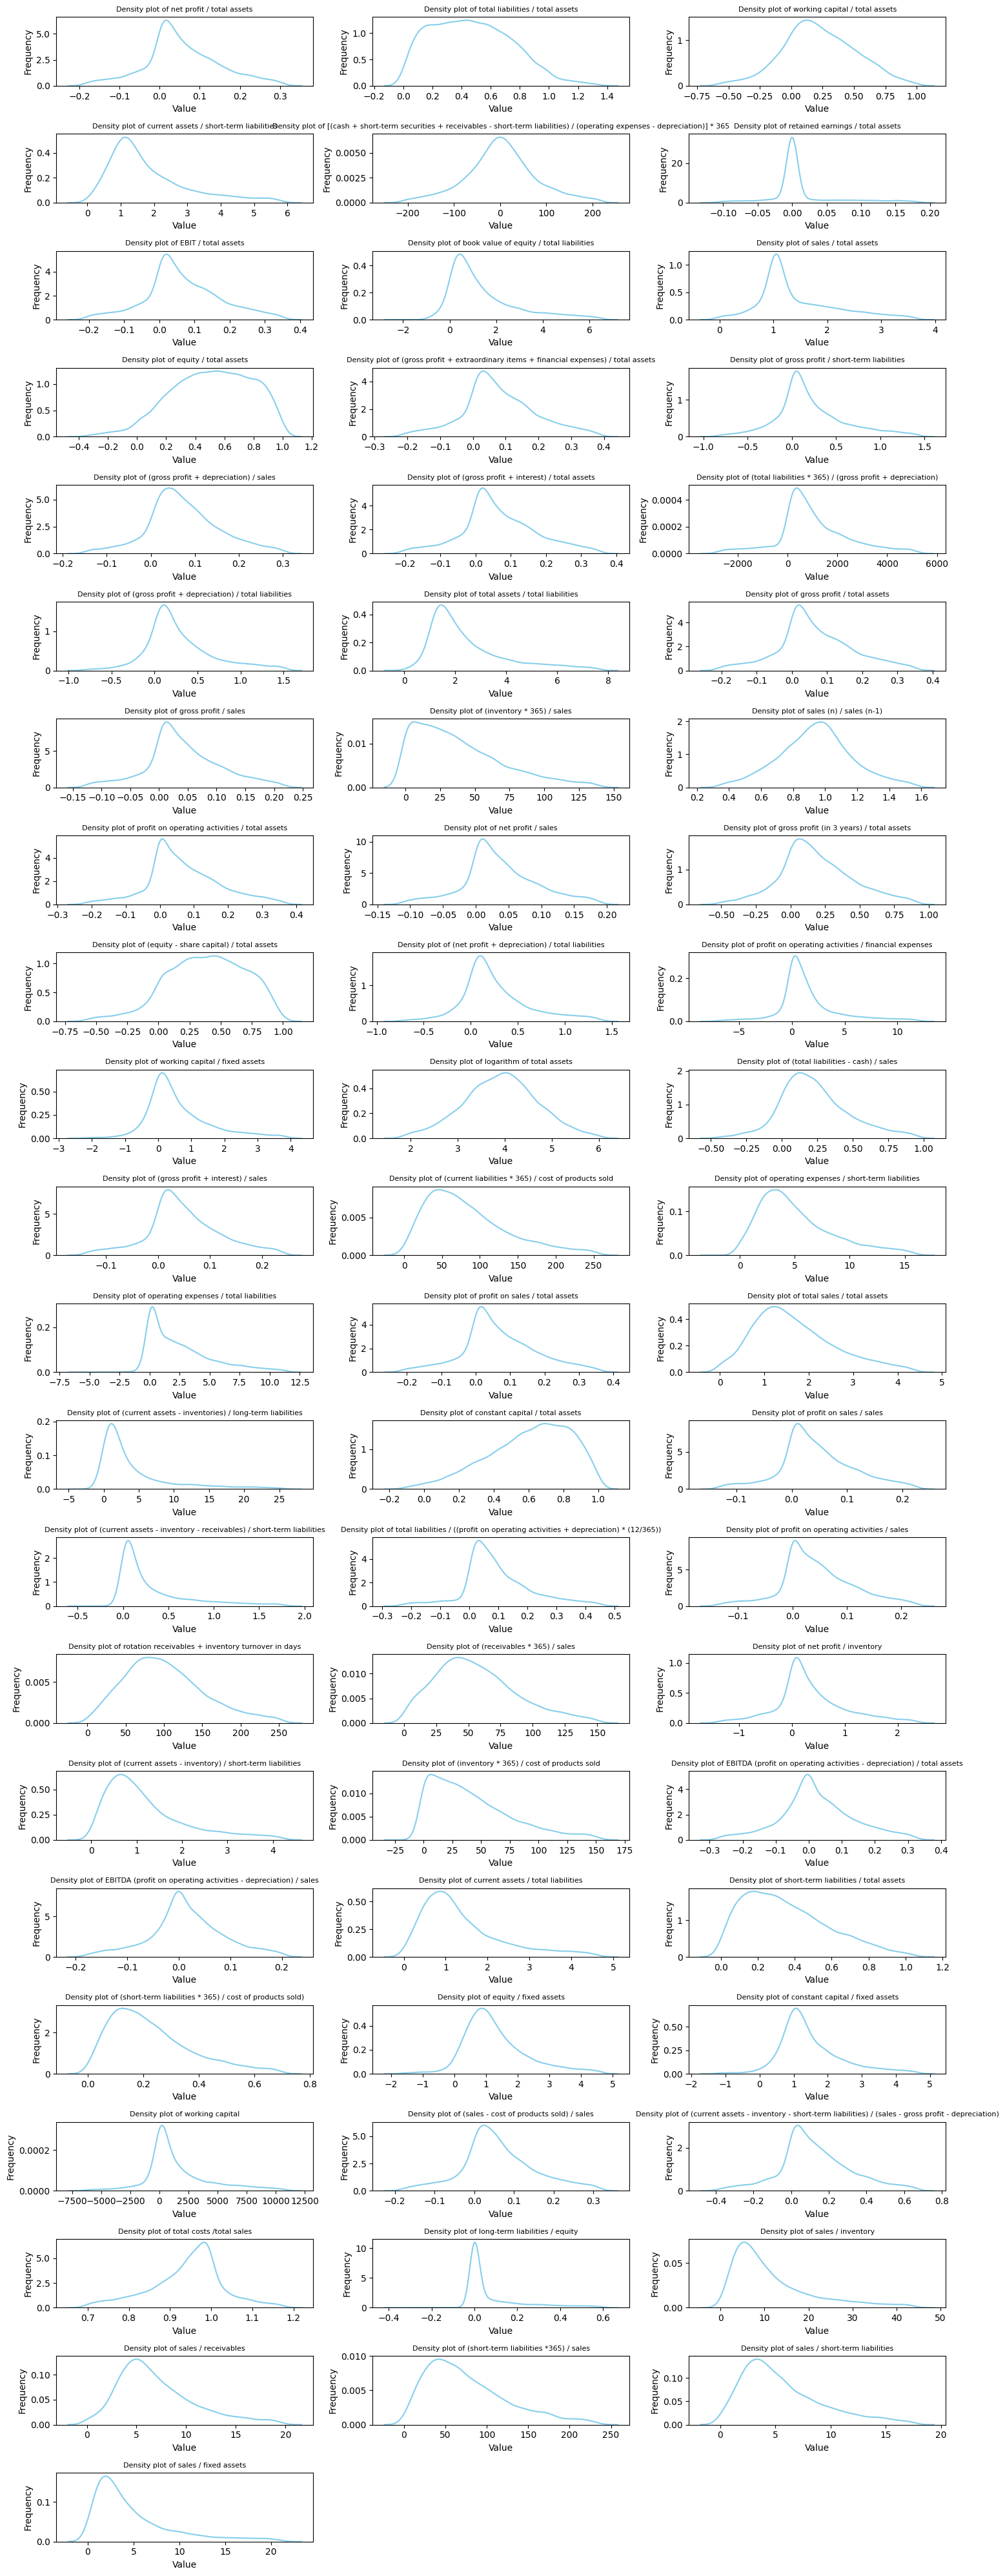

In [15]:
plt.figure(figsize=(15, 40))
for i, series in enumerate(clean_list, start=1):
    plt.subplot(22, 3, i)  # Adjust layout as needed
    sns.kdeplot(series, color="skyblue")
    plt.title(f"Density plot of {series.name}", fontsize=8)
    plt.xlabel("Value")
    plt.ylabel("Frequency")


plt.tight_layout()
plt.show()

##### Box plots

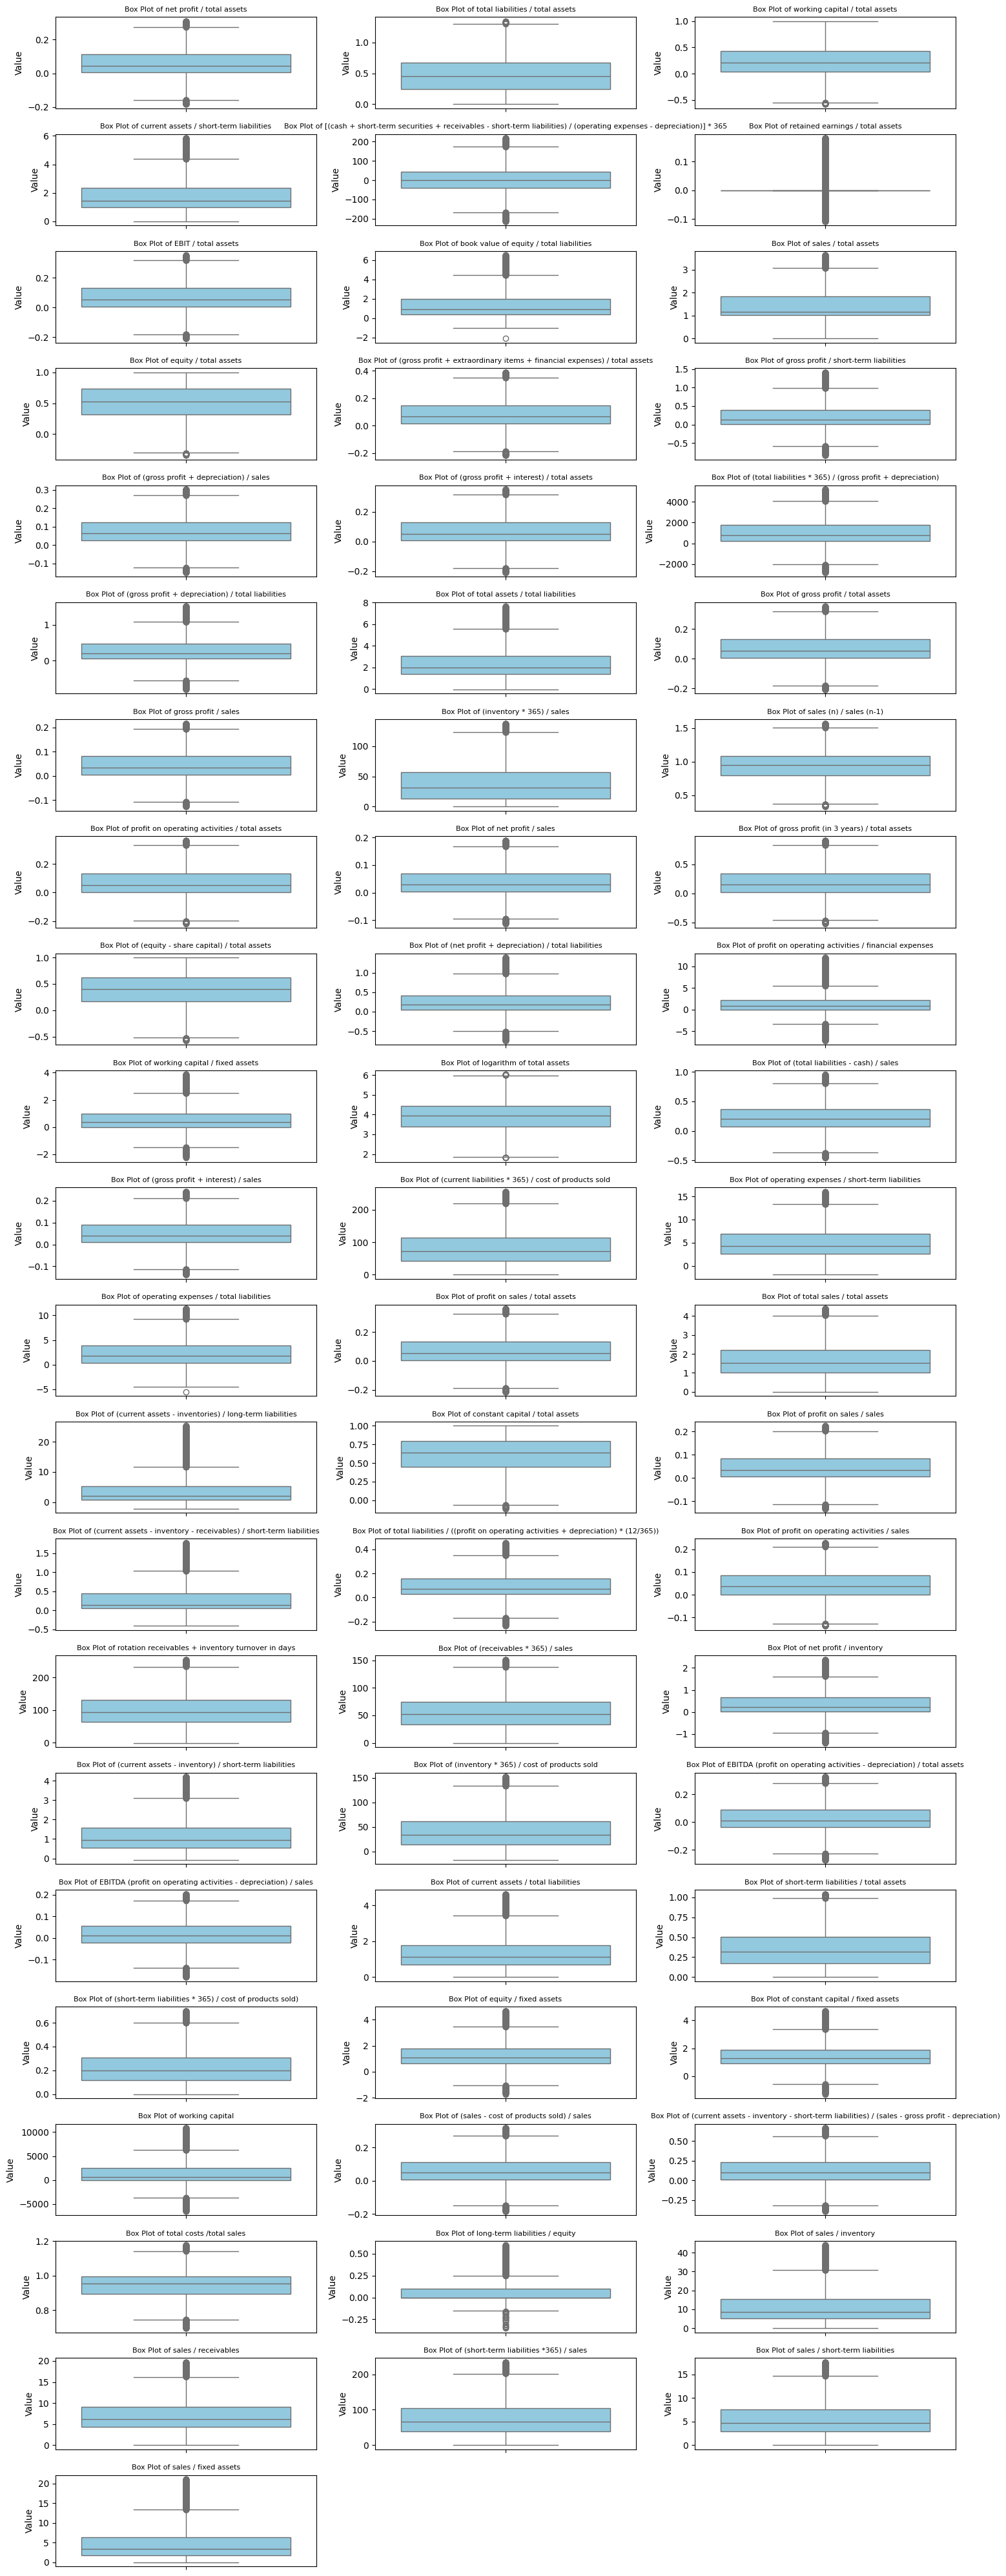

In [16]:
plt.figure(figsize=(15, 40))
for i, series in enumerate(clean_list, start=1):
    plt.subplot(22, 3, i)  # Adjust layout as needed
    sns.boxplot(data=series, color="skyblue")
    plt.title(f"Box Plot of {series.name}", fontsize=8)
    plt.ylabel("Value")

plt.tight_layout()
plt.show()

After removing the outliers, it becomes apparent that the majority of features exhibit smoother distributions. Nonetheless, due to the substantial presence of outliers, we have opted against their removal in subsequent data processing steps to prevent information loss.




#### 2.2.3 Correlation within features<a id="section2_2_3"></a>
By using heatmap, we explore the correlation and relationship within each pair of features to ease the feature selection process



### 2.3 Data Pre-Processing <a class="anchor" id="section2_3"></a>

In this section, we prepare our dataset by performing data pre-processing. Raw data often contains inconsistencies, missing values, and outliers that can negatively impact the performance of machine learning models. Data pre-processing ensures the data is clean, consistent, and formatted appropriately for our modelling tasks.

In [15]:
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

The function below converts the target column to binary values.

In [1]:
def as_discrete(col):
    n = len(col)
    new_col = [0] * n
    for i in range(n):
        if col[i] == b"0":
            new_col[i] = 0
        else:
            new_col[i] = 1
    return pd.DataFrame(new_col)

The function below splits the feature space and the target column.

In [ ]:
# function to separate features and target
def get_Xy(df):
    X = df.iloc[:, 0 : len(df.columns) - 1]
    y = as_discrete(df.iloc[:, -1])
    return X, y

From EDA, it is observed that there are many missing values in the dataset. We removed the column with more than 40% values missing as it is a significant loss of information. Rows with more than half of the values missing are also removed. For the remaining missing values, median imputation is used in view of the presence of drastic outliers in the dataset. 

In [ ]:
# function to handle missing values
def med_impute(df, y):
    # remove columns with more than 40% values being null
    thd1 = df.shape[0] * 0.4
    cols = df.columns[df.isnull().sum() < thd1]
    df = df[cols]

    # remove rows with more than 50% values being null
    thd2 = df.shape[1] * 0.5
    y = y[df.isnull().sum(axis=1) <= thd2]
    df = df[df.isnull().sum(axis=1) <= thd2]

    # median imputation for null values
    df = df.fillna(df.median())

    return df, y

In [2]:
# function to normalise numerical columns to remove effect of inconsistent scales
def normalise(df):
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return X_scaled

In [27]:
# funciton for feature selection
def drop_high_corr(df, threshold=0.7):
    correlation_matrix = df.corr()
    high_cor = []
    dropped_features = []

    # Iterate through the correlation matrix to find highly correlated pairs
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                if correlation_matrix.columns[j] != correlation_matrix.columns[i]:
                    high_cor.append(
                        [
                            correlation_matrix.columns[i],
                            correlation_matrix.columns[j],
                            correlation_matrix.iloc[i, j],
                        ]
                    )

    # Iterate through the list of highly correlated pairs
    for pair in high_cor:
        feature1, feature2, correlation = pair

        # Check if either of the features in the pair has already been dropped
        if feature1 not in dropped_features and feature2 not in dropped_features:
            # Check if the feature exists in the DataFrame before attempting to drop it
            if feature2 in df.columns:
                # Drop one of the correlated features from the dataset
                # Here, we arbitrarily choose to drop the second feature in the pair
                df.drop(feature2, axis=1, inplace=True)
                dropped_features.append(feature2)
            else:
                print("Feature '" + feature2 + "' not found in the DataFrame.")
    return df


# funciton to pre-process the data
def process1(df):
    X, y = get_Xy(df)
    X_imputed, y = med_impute(X, y)
    X_scaled_df = normalise(X_imputed)
    return drop_high_corr(X_scaled_df), y


# function to obtain train and test sets
def process2(df):
    X, y = process1(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )

    return X_train, X_test, y_train, y_test


# function to obtain train and test sets with sythesised instances of the minority class
def pre_process(df):
    X, y = process1(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )
    smote = SMOTE(random_state=3244)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    return X_smote, X_test, y_smote, y_test

### 2.3.1 ANOVA test for feature selection
We will also perform feature selection for our dataset, because irrelavant features can:
- **Increase Model Complexity**: Unnecessary features can lead to overfitting, where the model performs well on training data but poorly on unseen data.
- **Reduce Model Interpretability**: A large number of features makes it difficult to understand how the model arrives at its predictions.
- **Slow Down Training Time**: Training models with irrelevant features takes longer and consumes more computational resources.

One method of feature selection is ANOVA test, defined in: `get_df_with_top_k_features` and `find_best_k_features_from_ANOVA`

**ANOVA (Analysis of Variance)** is a statistical test used in feature selection to identify features that have a significant influence on the target variable. Here's how it helps select the best k features (where k is a chosen number):

- Focuses on Variance: ANOVA analyses the variation in a feature's values. It compares the variation between groups (bankrupt vs. non-bankrupt) to the variation within each group.
- Low p-value indicates Impact: Features with a low p-value (from the F-statistic) suggest a strong statistical difference in the feature's values between bankrupt and non-bankrupt companies. This implies the feature likely has a real impact on predicting bankruptcy.

In [17]:
def plot_ANOVA_test_graph(train_acc_dict, test_acc_dict):
    # Extract keys and values from train_acc_dict and test_acc_dict
    train_k_values, train_accuracy_values = zip(*train_acc_dict.items())
    test_k_values, test_accuracy_values = zip(*test_acc_dict.items())

    plt.figure(figsize=(6, 4))
    # Plot train accuracy
    plt.plot(
        train_k_values, train_accuracy_values, label="Train Accuracy", color="blue"
    )
    # Plot test accuracy
    plt.plot(test_k_values, test_accuracy_values, label="Test Accuracy", color="green")

    # Find k values corresponding to maximum accuracies
    best_train_k = max(train_acc_dict, key=train_acc_dict.get)
    best_test_k = max(test_acc_dict, key=test_acc_dict.get)
    best_train_accuracy = train_acc_dict[best_train_k]
    best_test_accuracy = test_acc_dict[best_test_k]

    # Annotate the point corresponding to the peak train accuracy
    plt.annotate(
        f"Max Train Accuracy\nk={best_train_k}, Acc={best_train_accuracy:.2f}",
        xy=(best_train_k, best_train_accuracy),
        xytext=(-30, 20),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="blue"),
    )

    # Annotate the point corresponding to the peak test accuracy
    plt.annotate(
        f"Max Test Accuracy\nk={best_test_k}, Acc={best_test_accuracy:.2f}",
        xy=(best_test_k, best_test_accuracy),
        xytext=(30, -30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="green"),
    )

    # Label axes and add title
    plt.xlabel("Number of Features (k)")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Number of Features from ANOVA test")

    plt.legend()
    plt.show()


## Note: *args follow the convention X_train, X_test, y_train, y_test
def get_df_with_top_k_features(k_features, *args):  # after pre_process(df)
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # define feature selection
    fs = SelectKBest(score_func=f_classif, k=k_features)

    # apply feature selection
    fs.fit_transform(X_train, y_train)

    # Take the features with the highest F-scores
    fs_scores_array = np.array(fs.scores_)

    # Get the indices that would sort the array in descending order
    sorted_indices_desc = np.argsort(fs_scores_array)[::-1]

    # Take the top k indices
    top_indices = sorted_indices_desc[:k_features]

    selected_columns_X_train = X_train.iloc[:, top_indices]
    selected_columns_X_test = X_test.iloc[:, top_indices]

    return selected_columns_X_train, selected_columns_X_test, y_train, y_test


def find_best_k_features_from_ANOVA(model, *args):
    # output: X_y training & test dataset that gives the best test accuracy
    # model: input is *previous_args
    #        output is train_accuracy, test_accuracy

    X_train = args[0]
    original_n_features = len(X_train.columns)

    # find the optimum number of features that gives the best test accuracy
    train_acc_dict = {}  # 0 is a dummy accuracy for k=0 features
    test_acc_dict = {}
    train_test_dataset = {}

    for k in range(1, original_n_features + 1):
        train_test_dataset_after_ANOVA = get_df_with_top_k_features(k, *args)
        train_accuracy, test_accuracy = model(*train_test_dataset_after_ANOVA)
        train_test_dataset[k] = train_test_dataset_after_ANOVA
        train_acc_dict[k] = train_accuracy
        test_acc_dict[k] = test_accuracy

    # Find k that gives the highest accuracy
    best_train_k = max(train_acc_dict, key=train_acc_dict.get)
    best_test_k = max(test_acc_dict, key=test_acc_dict.get)

    print(f"\033[96mBest k for train_accuracy:\033[00m {best_train_k}")
    print(f"\033[96mBest k for test_accuracy:\033[00m {best_test_k}")

    plot_ANOVA_test_graph(train_acc_dict, test_acc_dict)

    return train_test_dataset[best_test_k]

Moving forward, we can use ANOVA test for feature selection to reduce the number of features in our dataset before building our model.

## Chapter 3: Modelling <a class="anchor" id="chapter3"></a>

### 3.1 Evaluation Metrics  <a class="anchor" id="section3_1"></a>

Our primary task is to predict bankruptcy (a classification problem). Below are the key classification metrics that we will use to evaluate our model performance:

#### 3.1.1 Accuracy
Accuracy provides a ratio of correctly predicted observations to the total observations. It is especially useful when the classes are balanced with SMOTE.

**Formula**:
$$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}$$

#### 3.1.2 Confusion Matrix and Related Terms
The confusion matrix is a table layout that allows visualization of the performance of the algorithm, where each number in the matrix represents:
- **TP (True Positives)**: Correctly predicted positive observations.
- **TN (True Negatives)**: Correctly predicted negative observations.
- **FP (False Positives)**: Incorrectly predicted as positive.
- **FN (False Negatives)**: Incorrectly predicted as negative.

#### 3.1.3 Precision, Recall, and F1-Score
These metrics offer a deeper understanding of the model's performance by taking into account data imbalances, thereby providing a more nuanced view of the accuracy across different class labels.

- **Precision**:
$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$
Precision measures the accuracy of positive predictions.

- **Recall** (or Sensitivity or TPR):
$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
Recall measures the ability of a model to find all the relevant cases (all positive samples).

- **F1-Score**:
$$ \text{F1-Score} = 2 \times \left( \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} \right) $$
The F1-Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. A high F1-score shows a model can classify the positive class correctly, while not misclassifying many negative classes as positive.

#### 3.1.4 Macro Average vs Micro Average

- **Macro Average**: Macro average calculates the metric independently for each class and then takes the average (hence treating all classes equally). It is useful equal weight is given to the performance of each class, regardless of its frequency.

- **Micro Average**: Micro average aggregates the contributions of all classes to compute the average metric. In other words, Micro Average will compute the overall total TP, FP, and FN across all classes, and then use these totals to calculate the performance scores. It is useful when metrics are weighted by class size, which is ideal for imbalanced data as it reflects the contribution of each class proportionally to its size.


In [18]:
# import evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)


# function to print all evaluation results
def get_acc(y_test, y_pred):
    return round(accuracy_score(y_test, y_pred), 3)


def get_pre(y_test, y_pred):
    return round(precision_score(y_test, y_pred), 3)


def get_rec(y_test, y_pred):
    return round(recall_score(y_test, y_pred), 3)


def get_f1(y_test, y_pred):
    return round(f1_score(y_test, y_pred), 3)


def print_res(y_test, y_pred):
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Accuracy:", get_acc(y_test, y_pred))
    print("Precision Score:", get_pre(y_test, y_pred))
    print("Recall Score:", get_rec(y_test, y_pred))
    print("F1 Score:", get_f1(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

### 3.2 Machine Learning Model Packages <a class="anchor" id="section3_2"></a>

#### 3.2.1 Scikit-learn (sklearn)
- **KNeighborsClassifier**: This model implements the k-nearest neighbors voting algorithm.
- **LogisticRegression**: A model that applies logistic regression for binary classification tasks.
- **SVC**: Support Vector Machine classifier known for its effectiveness in high-dimensional spaces.
- **DecisionTreeClassifier**: A model that uses a decision tree for classification, useful for interpretability.
- **GradientBoostingClassifier**: An ensemble model that builds on weak prediction models to create a strong classifier.
- **RandomForestClassifier**: A meta estimator that fits a number of decision tree classifiers to various sub-samples of the dataset and uses averaging to improve predictive accuracy and control overfitting.

#### 3.2.2 Imbalanced-learn (imblearn)
Dealing with imbalanced data:

- **BalancedRandomForestClassifier**: A variation of the RandomForest that handles imbalances by adjusting weights inversely proportional to class frequencies in the input data.

#### 3.2.3 XGBoost (xgboost)

- **XGBoost**: An implementation of gradient boosted decision trees designed for speed and performance.


In [19]:
# sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# imblearn
from imblearn.ensemble import BalancedRandomForestClassifier

# XGBoost
import xgboost as xgb

### 3.3 Model Evaluations <a class="anchor" id="section3_3"></a>

In this section, we present the classification performance of all the Machine Learning Models that we used. We first evaluate the performance of a simple logistic regression to establish a benchmark for classification performance. Next, we explored other simple models, in the order of K-Nearest Neighbours, Support Vector Machine and Decision Tree. After that, we experimented with emsemble methods, including Random Forest and Balanced Random Forest. 

We will present a summary of the performance evaluations of all the models in the section 3.4. 


In [ ]:
import warnings

warnings.filterwarnings("ignore")

#### 3.3.1 Logistic regression
As the benchmark model, the logistic regression model provides an initial overview of how well simple models can predict outcomes based on our data.

In [26]:
from sklearn.linear_model import LogisticRegression

data = arff.loadarff("../../data/3year.arff")
df = pd.DataFrame(data[0])
X_train, X_test, y_train, y_test = pre_process(df)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[1699 1318]
 [  64   70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.56      0.71      3017
           1       0.05      0.52      0.09       134

    accuracy                           0.56      3151
   macro avg       0.51      0.54      0.40      3151
weighted avg       0.92      0.56      0.68      3151



#### 3.3.2 K-Nearest Neighbors (KNN)
We continue our modeling with the K-Nearest Neighbors (KNN) algorithm to compare its performance against the baseline established by logistic regression. KNN is a technique that predicts the class of a given point based on the majority vote of its nearest neighbors. KNN is useful for gaining insights into the dataset’s structure due to its reliance on feature similarity. 

In [ ]:
# knn code here

Given the high dimensionality of our dataset, even after data cleaning, the KNN model might not perform optimally due to its known limitations with high-dimensional data. To address this issue, we apply Principal Component Analysis (PCA) to reduce the dimensionality. This step aims to enhance the performance of our KNN model by focusing on the most significant features and reducing the noise associated with less important variables.

In [ ]:
# knn with pca code here

#### 3.3.3 Support Vector Machine (SVM)
We further our analysis by incorporating a Support Vector Machine (SVM) model to assess its effectiveness compared to the simpler models previously tested. SVM is a classification technique that finds the optimal hyperplane which best separates the data into different classes. It addresses the short comings of KNN, as it performs well in high-dimensional space and work well with non-linearly separable data.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


def SVM_return_model(*args, kernel_type_):
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # Reset indices to ensure alignment
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    # Training the SVM model
    svm_model = SVC(kernel=kernel_type_)
    print(f"\nkernel_type: {kernel_type_}")
    svm_model.fit(X_train, y_train)

    # Predictions on the testing set
    y_pred_train = svm_model.predict(X_train)
    y_pred_test = svm_model.predict(X_test)

    # Evaluating the model
    train_accuracy = accuracy_score(y_train, y_pred_train)
    print_res(y_test, y_pred_test)
    print(f"train_accuracy: {train_accuracy}")
    return svm_model


def SVM_sigmoid_model(*args):  # for ANOVA
    X_train = args[0]
    X_test = args[1]
    y_train = args[2]
    y_test = args[3]

    # Reset indices to ensure alignment
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    model = SVM_return_model(*args, kernel_type_="sigmoid")
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluating the model
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    return train_accuracy, test_accuracy

In [ ]:
train_test_dataset = pre_process(df)

kernel_list = ["linear", "poly", "rbf", "sigmoid"]
kernel_dict = dict()

for kernel_type in kernel_list:
    print(f"\033[96m{kernel_type}\033[00m")
    model = SVM_return_model(*train_test_dataset, kernel_type_=kernel_type)

# we found that sigmoid gives the best test accuracy
best_kernel_type = "sigmoid"

# use ANOVA test for feature selection
best_train_test_dataset = dp.find_best_k_features_from_ANOVA(
    SVM_sigmoid_model, *train_test_dataset
)

# Now we create a SVM model based on the top 25 features after ANOVA test, and sigmoid as kernel
SVM_model2 = SVM_return_model(*best_train_test_dataset, kernel_type_=best_kernel_type)

X_train1, X_test1, y_train1, y_test1 = best_train_test_dataset
conf_matrix = confusion_matrix(y_test1, y_test1)

The Support Vector Machine (SVM) model has not performed as expected in our analysis for several reasons:

1. **Sensitivity to Outliers**: SVM is particularly sensitive to outliers. In our dataset, we retained outliers to capture distinctive characteristics of different companies with respect to their bankruptcy status. This sensitivity can lead to skewed decision boundaries, adversely affecting model performance. 

2. **Overfitting Issues**: In this analysis, the SVM model has shown a tendency to overfit. This issue stems from the lack of an appropriate regularization function. Without proper regularization, SVM models can overly conform to the noise in the training data rather than capturing the general pattern, leading to poor generalization on new, unseen data.

Hence, this prompt us to improve our SVM model with grid search method.

In [ ]:
param_grid = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
}

# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid = GridSearchCV(SVM_model2, param_grid, refit=True, verbose=3)

# fitting the model for grid search
grid.fit(X_train1, y_train1)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

grid_predictions = grid.predict(X_test1)

# print classification report (without grid search)
print("SVM model without grid-search")
y_pred_test = SVM_model2.predict(X_test1)
print(confusion_matrix(y_test1, y_pred_test))
clf = SVM_return_model(
    *best_train_test_dataset, best_kernel_type
)  # to print accuracy score

# print classification report with grid search
print("\nSVM model with grid-search")
print(confusion_matrix(y_test1, grid_predictions))
print(classification_report(y_test1, grid_predictions))

#### 3.3.4 Decision Tree
A Decision Tree  works by splitting the dataset into smaller subsets based on feature values, thereby creating a tree structure. Each split is strategically made to maximize information gain—the reduction in entropy or disorder after the split. 

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print_res(y_test, y_pred)

With grid search, we found the Best parameters: {'max_depth': 40, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}.
We further explore the model performance:

In [ ]:
dt = DecisionTreeClassifier(
    max_depth=40, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2
)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print_res(y_test, y_pred)

### 4.3.5 Random Forest
Random forest method is introduced as an improvement over single decision trees to reduce overfitting and improve predictive performance. Two underlying principles of random forest are:
1. **Bagging**: It creates multiple subsets of the training data through random sampling with replacement and using these subsets to train a collection of decision trees (weak learners). This method aims to reduce variance of prediction result.
2. **Random Subspace**: The random forest randomly selects a subset of features  from the original feature set for each individual decision tree within the ensemble. By allowing each tree to focus on a different subset of features, the random forest can capture different patterns and relationships within the data, leading to more accurate and stable predictions.

In [ ]:
# random forest initial trial
rdt = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

rdt.fit(X_train, y_train)
y_pred = rdt.predict(X_test)

print_res(y_test, y_pred)

In [ ]:
# random forest with grid search best model
rdt = RandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    min_samples_leaf=4,  # Increased from 1 to 4
    min_samples_split=10,  # Increased from 2 to 10
    max_depth=25,
    class_weight={0: 0.7, 1: 0.32},
    bootstrap=True,
    min_impurity_decrease=0.00001,
    random_state=42,
)

rdt.fit(X_train, y_train)
y_pred = rdt.predict(X_test)

print_res(y_test, y_pred)

During the model fitting process, we found out that the model could overfit on the training data, hence we proceed to reduce the dimension of our data with feature selection using forward selection loop.

In [ ]:
# random forest with forward selection
selected_features = []
best_f1 = 0
features = list(X_train.columns)

# Forward Selection
for _ in range(len(features)):
    f1_scores = []
    for feature in features:
        if feature not in selected_features:
            temp_features = selected_features + [feature]
            rdt = RandomForestClassifier(
                n_estimators=100,
                max_features="sqrt",
                min_samples_leaf=4,  # Increased from 1 to 4
                min_samples_split=10,  # Increased from 2 to 10
                max_depth=25,
                class_weight={0: 0.7, 1: 0.32},
                bootstrap=True,
                min_impurity_decrease=0.00001,
                random_state=42,
            )
            rdt.fit(X_train[temp_features], y_train)
            y_pred = rdt.predict(X_test[temp_features])
            f1 = f1_score(y_test, y_pred)
            f1_scores.append((feature, f1))

    f1_scores.sort(key=lambda x: x[1], reverse=True)
    best_feature, best_feature_f1 = f1_scores[0]

    if best_feature_f1 > best_f1:
        print(f"Adding {best_feature} improved F1 to {best_feature_f1}")
        best_f1 = best_feature_f1
        selected_features.append(best_feature)
    else:
        break

print("Selected features:", selected_features)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

rdt_selected = RandomForestClassifier(
    n_estimators=200, max_features="sqrt", min_samples_leaf=1, min_samples_split=2
)
rdt_selected.fit(X_train_selected, y_train)
y_pred_selected = rdt_selected.predict(X_test_selected)

print_res(y_test, y_pred_selected)

### 4.3.6 Balanced Random Forest (BRF)
The Balanced Random Forest (BRF) method enhances the traditional Random Forest by specifically addressing class imbalance in training datasets. This approach boosts predictive accuracy and fairness for unbalanced data. BRF tackles Random Forest’s limitations by ensuring equal class representation in each bootstrap sample, achieved through either downsampling or oversampling. The following code demonstrates the BRF implementation on an imbalanced insurance dataset.

In [ ]:
# balanced random forest initial trial
brf = BalancedRandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)

print_res(y_test, y_pred)

In [ ]:
# balanced random forest with grid search best model
brt = BalancedRandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    min_samples_leaf=4,
    min_samples_split=10,
    max_depth=25,
    class_weight={0: 0.7, 1: 0.32},  # this is manually adjusted
    bootstrap=True,
    min_impurity_decrease=0.00001,
    random_state=42,
)

brt.fit(X_train_selected, y_train)
y_pred = brt.predict(X_test_selected)

print_res(y_test, y_pred)

Same as random forest, one downside of hyperparameter tuning with grid search is that it could potentially lead to overfitting of the training data. We also try to reduce this via forward feature selection.

In [ ]:
# Balanced random forest with forward selection
selected_features = []
best_f1 = 0
features = list(X_train.columns)

# Forward Selection
for _ in range(len(features)):
    f1_scores = []
    for feature in features:
        if feature not in selected_features:
            temp_features = selected_features + [feature]
            brt = BalancedRandomForestClassifier(
                n_estimators=100,
                max_features="sqrt",
                min_samples_leaf=4,  # Increased from 1 to 4
                min_samples_split=10,  # Increased from 2 to 10
                max_depth=25,
                class_weight={0: 0.7, 1: 0.32},
                bootstrap=True,
                min_impurity_decrease=0.00001,
                random_state=42,
            )
            brt.fit(X_train[temp_features], y_train)
            y_pred = brt.predict(X_test[temp_features])
            f1 = f1_score(y_test, y_pred)
            f1_scores.append((feature, f1))

    f1_scores.sort(key=lambda x: x[1], reverse=True)
    best_feature, best_feature_f1 = f1_scores[0]

    if best_feature_f1 > best_f1:
        print(f"Adding {best_feature} improved F1 to {best_feature_f1}")
        best_f1 = best_feature_f1
        selected_features.append(best_feature)
    else:
        break

print("Selected features:", selected_features)

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

brf_selected = BalancedRandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    min_samples_leaf=4,  # Increased from 1 to 4
    min_samples_split=10,  # Increased from 2 to 10
    max_depth=25,
    class_weight={0: 0.7, 1: 0.32},
    bootstrap=True,
    min_impurity_decrease=0.00001,
    random_state=42,
)
brf_selected.fit(X_train_selected, y_train)
y_pred_selected = brf_selected.predict(X_test_selected)


print_res(y_test, y_pred_selected)

# Step 6: Numerical results

After experimenting with different models and different feature selection and fine-tuning methods, we have summarise the model metrics below.

|No | Model| Feature Selection | With SMOTE | Model Improvement methods| Test Accuracy	| Precision |	Recall | F1-score |
|:---------|:--------:|---------:|:---------|:--------:|---------:|:---------|:--------:|---------:|
|  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   | 
|  Row 2   |  Row 2   |  Row 2   | Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   | 
|  Row 3   |  Row 3   |  Row 3   | Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   |  Row 1   | 

Overall, we see that....

We choose to priorise recall rather than precision because...